In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

# Generate data

In [2]:
X, y = make_blobs(n_samples=400, n_features=2, cluster_std=3, random_state=11)
print(X.shape, y.shape)

(400, 2) (400,)


# Plot data

In [3]:
def plot_data(X, y):
    plt.scatter(*X[y==0].T, color='g', label='0')
    plt.scatter(*X[y==1].T, color='b', label='1')
    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')
    plt.legend()
    plt.show()

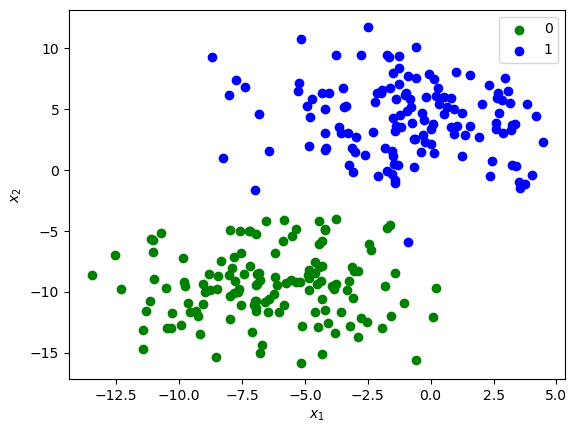

In [4]:
plot_data(X, y)

# Split data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    shuffle=True)

print(X_train.shape, X_test.shape) 

(320, 2) (80, 2)


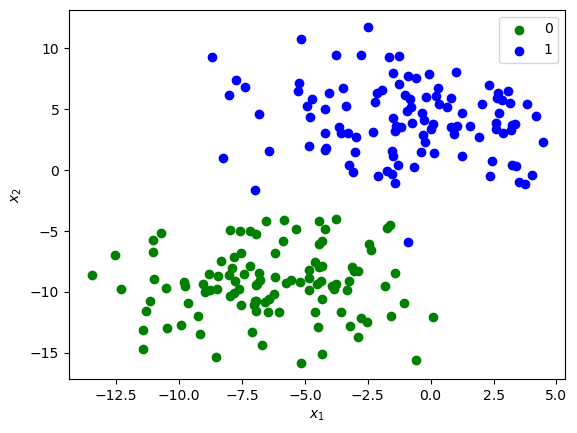

In [6]:
plot_data(X_train, y_train)

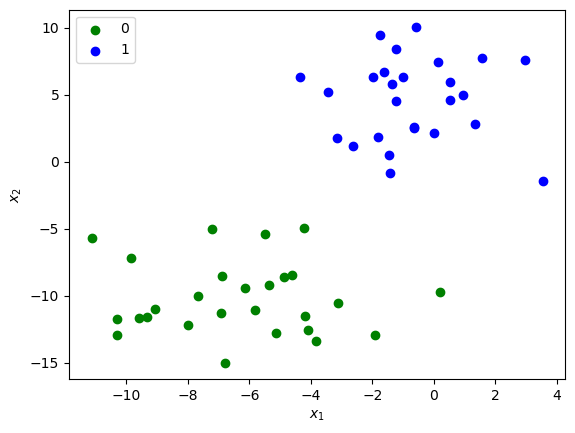

In [7]:
plot_data(X_test, y_test)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

# Custom KNN

In [9]:
class KNNClassifier:
    def __init__(self, n_neighbors=5):
        """KNN Classifier

        Args:
            n_neighbors (int, optional): Number of neighbors. Defaults to 5.
        """
        self.n_neighbors = n_neighbors

    def _euclidean_distance(self, X1, X2):
        """Computes euclidean distance.

        Args:
            X1 (array): Input 1
            X2 (array): Input 2

        Returns:
            float: Euclidean distance
        """
        X1 = np.array(X1)
        X2 = np.array(X2)
        return np.sqrt(np.mean((X1-X2)**2, axis=-1))
    
    def _vote(self, labels):
        """Find most common label

        Args:
            labels (array): Labels
        
        Returns:
            int: Label
        """
        count = np.bincount(labels.astype(int))
        return count.argmax()
    
    def _calculate_proba(self, labels):
        """Calculate porbabilities.

        Args:
            labels (array): Labels

        Returns:
            array: Probabilities
        """
        hist, _ = np.histogram(labels,
                               bins=self.n_classes,
                               range=(0, self.n_classes))
        probabilities = hist/len(labels)
        return probabilities
        
    def fit(self, X, y):
        """Fit

        Args:
            X (array): Features
            y (array): Labels
        """
        self.X = X
        self.y = y
        self.n_classes = len(np.unique(y))        

    def predict(self, X):
        """Predict

        Args:
            X (array): Features

        Returns:
            array: Predictions
        """
        # Simple way
        
        # y_pred = np.zeros(X.shape[0])
        # for idx, row in enumerate(X):
        #     # Compute distances and pick nearest neighbors
        #     neighbors_idx = np.argsort(
        #                     [self._euclidean_distance(row, pt) for pt in self.X]
        #                     )[:self.n_neighbors]
        #     neighbor_labels = self.y[neighbors_idx]
        #     # Find the majority
        #     y_pred[idx] = self._vote(neighbor_labels)
        
        # Optimized way
        
        # computes pairwise distance
        distances = cdist(X, self.X, metric='euclidean')
        
        # Find nearest neighbors 
        # To understand argpartition better,
        # refer https://stackoverflow.com/questions/52465066/how-does-numpys-argpartition-work-on-the-documentations-example
        neighbors_idx = np.argpartition(distances, self.n_neighbors)[:, :self.n_neighbors]
        
        neighbor_labels = self.y[neighbors_idx]    
        y_pred = np.array([self._vote(labels) for labels in neighbor_labels])
        return y_pred
            

    def predict_proba(self, X):
        """Predict

        Args:
            X (array): Features

        Returns:
            array: Predictions
        """
        # Simple way
        
        # y_pred = np.zeros(shape=(X.shape[0], self.n_classes))
        # for idx, row in enumerate(X):
        #     # Compute distances and pick nearest neighbors
        #     neighbors_idx = np.argsort(
        #                     [self._euclidean_distance(row, pt) for pt in self.X]
        #                     )[:self.n_neighbors]
        #     neighbor_labels = np.array([self.y[i] for i in neighbors_idx])
        #     # Find the majority
        #     y_pred[idx] = self._calculate_proba(neighbor_labels)
        
        # Optimized way
        
        # computes pairwise distance
        distances = cdist(X, self.X, metric='euclidean')
        
        # Find nearest neighbors 
        # To understand argpartition better,
        # refer https://stackoverflow.com/questions/52465066/how-does-numpys-argpartition-work-on-the-documentations-example
        neighbors_idx = np.argpartition(distances, self.n_neighbors)[:, :self.n_neighbors]
        
        neighbor_labels = self.y[neighbors_idx]    
        y_pred = np.array([self._calculate_proba(labels) for labels in neighbor_labels])
         
        return y_pred
    
    def score(self, X, y):
        """Predict and score

        Args:
            X (array): Features
            y (array): Labels

        Returns:
            float: accuracy score
        """
        y_pred = self.predict(X)
        return accuracy_score(y.astype(int), y_pred)

In [10]:
def plot_decision_boundary(model, X, y):
    """Predict and score

    Args:
        model (model): Classifier
        X (array): Features
        y (array): Labels
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(r'$X_1$')
    plt.ylabel(r'$X_2$')
    plt.title(f"Classification (k = {model.n_neighbors})")
    plt.show()

In [11]:
model1 = KNNClassifier(n_neighbors=5)
model1.fit(X_train, y_train)
print("Training accuracy: ", model1.score(X_train, y_train))
print("Testing accuracy: ", model1.score(X_test, y_test))
print("Probability prediction: ", model1.predict_proba(X_test[:1, :]))

Training accuracy:  0.834375
Testing accuracy:  0.8375
Probability prediction:  [[1. 0. 0.]]


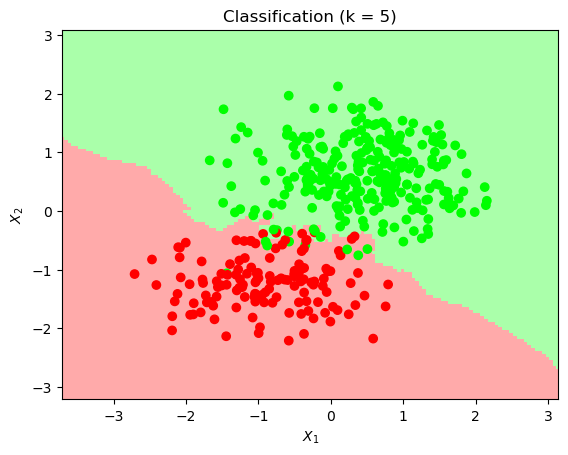

In [12]:
plot_decision_boundary(model1, X, y)

# Scikit-Learn API

In [13]:
model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(X_train, y_train)
print("Training accuracy: ", model2.score(X_train, y_train))
print("Testing accuracy: ", model2.score(X_test, y_test))
print("Probability prediction: ", model2.predict_proba(X_test[:1, :]))

Training accuracy:  0.834375
Testing accuracy:  0.8375
Probability prediction:  [[1. 0. 0.]]


We can observe that we are getting same results in both custom implementation and sklearn implementation.

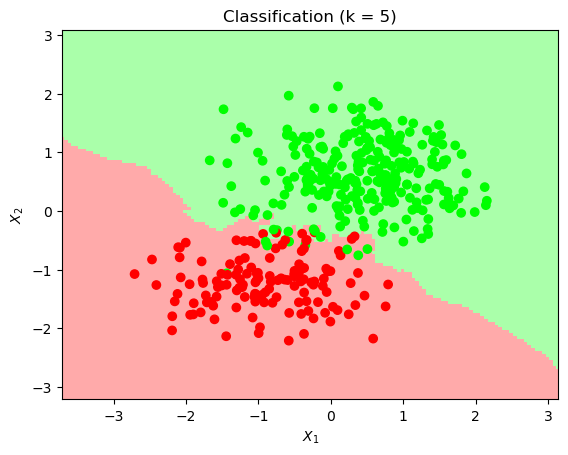

In [14]:
plot_decision_boundary(model2, X, y)

Do checkout my other kernels:

- [Linear Regression from scratch](https://www.kaggle.com/code/anilreddyvv/linear-regression-from-scratch)

- [Logistic Regression from scratch](https://www.kaggle.com/code/anilreddyvv/logistic-regression-from-scratch)

Follow for more implementations.